# 顔画像データの線形AutoEncoderによる次元圧縮

## 線形AutoEncoderによる次元圧縮と主成分分析

出力層のニューロン数が入力の次元数と等しく，入力データそのものを出力の教師として学習するニューラルネットワークを AutoEncoder という．

## 準備

In [1]:
import numpy as np
import cv2
#import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import LFWDataset
import ipytools

## ネットワークの定義ほか

In [2]:
### definition of the network
#
class NN(nn.Module):

    def __init__(self, D=100, H=10):

        super(NN, self).__init__()
        # linear network => bias is not used
        self.fc1 = nn.Linear(D, H, bias=False)
        self.fc2 = nn.Linear(H, D, bias=False)

    def forward(self, X):
        Y = self.fc1(X)
        Z = self.fc2(Y)
        return Z

In [3]:
torch.manual_seed(0)

In [6]:
### device
#
use_gpu_if_available = True
if use_gpu_if_available and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print('# using', device)

# using cpu


## 学習データの準備

In [7]:
### preparing the data (L)
#
dsL = LFWDataset.LFWDataset(LT='L')
NL = dsL.ndat
D = dsL.ndim
print(NL, D)
batchsize = 32
dlL = torch.utils.data.DataLoader(dsL, batch_size=batchsize, shuffle=True, drop_last=True)
nbatch = len(dlL)

# dataRoot = data/lfw-selected
4000 36864


## ネットワークの初期化など学習の準備

In [8]:
### initializing the network
#
H = 100  # 隠れ層ニューロン数
network = NN(D=D, H=H)
model = network.to(device)
print(model)
#optimizer = optim.Adam(model.parameters())  # lr=0.001
optimizer = optim.Adam(model.parameters(), lr=0.0005)
print(optimizer)

NN(
  (fc1): Linear(in_features=36864, out_features=100, bias=False)
  (fc2): Linear(in_features=100, out_features=36864, bias=False)
)
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0005
    weight_decay: 0
)


## 学習

以下のセルを複数回実行すると，前のパラメータを使って学習の続きをやることになるので注意．

In [9]:
%%time
# ↑ このセルの実行時間を測る．マシンの性能にもよるが，5分から10分くらい？

### learning
#
nepoch = 50

for i in range(nepoch):

    model.train()

    sqeL = np.empty(nbatch)

    for ib, Xb in enumerate(dlL):

        optimizer.zero_grad()
        Z = model(Xb)
        loss = F.mse_loss(Xb, Z, reduction='mean')
        loss.backward()
        optimizer.step()

        sqeL[ib] = loss.clone().cpu().detach().numpy()
            
    msqeL = np.mean(sqeL) # We can compute 'mean of the means' so that all the batch has the same size.
    print(i, msqeL)

0 0.04601604546606541
1 0.024518044009804726
2 0.022254621669650077
3 0.022526443749666215
4 0.019254063956439495
5 0.017401333123445512
6 0.015664378501474858
7 0.014665246210992336
8 0.014613262861967086
9 0.010867424920201301
10 0.010615385212004185
11 0.009354990221560002
12 0.008122701391577721
13 0.007611182458698749
14 0.007379243336617947
15 0.007243350334465504
16 0.007015721365809441
17 0.006799109786748886
18 0.006576704390347004
19 0.006487228140234947
20 0.006219260476529599
21 0.006172721702605486
22 0.0059452978558838365
23 0.0059433959871530535
24 0.005870252538472414
25 0.005707013938575983
26 0.0053582143895328045
27 0.005539494439959526
28 0.005189809756353497
29 0.005083412989974022
30 0.004940357780084014
31 0.004838775280863046
32 0.004911656284704804
33 0.004791757928207517
34 0.004732445765286684
35 0.004817478843033313
36 0.004638689905405045
37 0.004649500280618667
38 0.004542976638302207
39 0.004622215999290347
40 0.004635469546541571
41 0.004574000000953675


## 学習データでの評価

In [10]:
### evaluation (L)
#
model.eval()
dlL = torch.utils.data.DataLoader(dsL, batch_size=batchsize, shuffle=False, drop_last=False)

for ib, Xb in enumerate(dlL):
    Z = model(Xb)
    loss = F.mse_loss(Xb, Z, reduction='sum')
    sqeL[ib] = loss.clone().cpu().detach().numpy()

msqeL = np.sum(sqeL) / (NL*D)

print(f'# L: {msqeL}')

# L: 0.0044437229666444995


## テストデータでの評価と画像の再構成

In [11]:
### evaluation & reconstruction (T)
#
model.eval()
dsT = LFWDataset.LFWDataset(LT='T')
NT = dsT.ndat
print(NT, D)
dlT = torch.utils.data.DataLoader(dsT, batch_size=batchsize, shuffle=False, drop_last=False)

sqeT = np.empty(len(dlT))
for ib, Xb in enumerate(dlT):
    Z = model(Xb)
    loss = F.mse_loss(Xb, Z, reduction='sum')
    sqeT[ib] = loss.clone().cpu().detach().numpy()
    if ib == 0:
        XT = Xb.cpu().detach().numpy()
        XT *= 255
        XT += dsT.meanL.reshape(-1)
        XT = np.clip(XT, 0, 255)
        ZT = Z.cpu().detach().numpy()
        ZT *= 255
        ZT += dsT.meanL.reshape(-1)
        ZT = np.clip(ZT, 0, 255)

msqeT = np.sum(sqeT) / (NT*D)
print(f'# T: {msqeT}')

# dataRoot = data/lfw-selected
1721 36864
# T: 0.004682486957296623


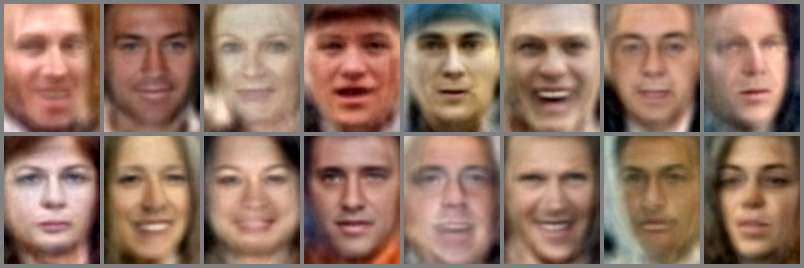

In [12]:
# 再構成画像
img = ipytools.mosaicImage(ZT[:16, ::], 8, 2)
#cv2.imwrite('hoge.png', img)
ipytools.displayImage(img)

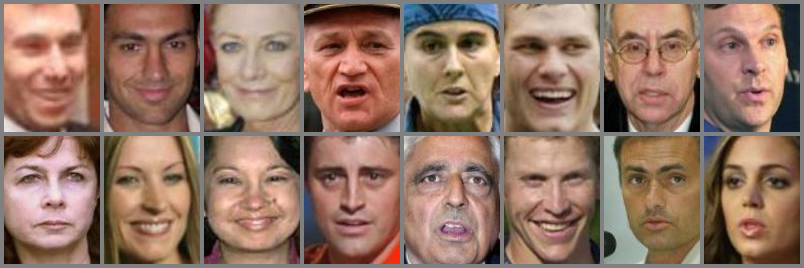

In [13]:
# 元画像
img = ipytools.mosaicImage(XT[:16, ::], 8, 2, nrow=128, ncol=96)
ipytools.displayImage(img)